# GitHub NLP Project
### Corey Solitaire and Angel Gomez
#### 10.23.2020

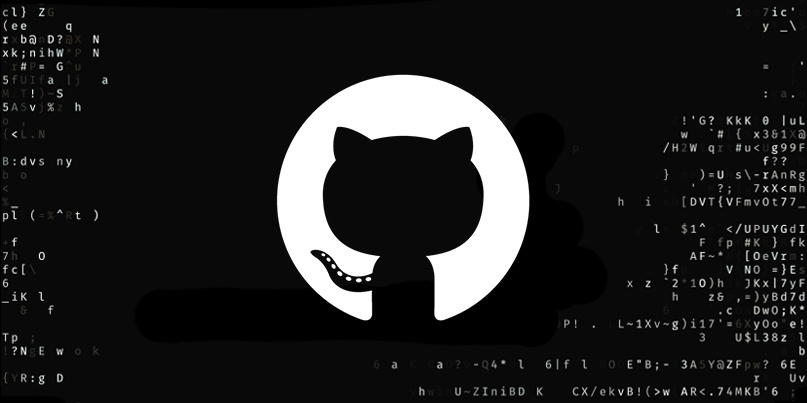

<div class="alert alert-block alert-info"><b></b></div>

## Executive Summary:
***

#### Project Summary:
*text*

#### Background:
*text*

#### Process:
*text*

#### Results:
*text*

#### Conclusion:
*text*

#### Recomendations:
*text*

<div class="alert alert-block alert-info"><b></b></div>

***
## Project Goals:
***

### 1. Build a web scraper that extracts the contents of 100 GitHub repository README.md texts as well as the            primary language of the repos.   
   
   
### 2. Use this data to build a classification model to predict the primary languae of the repository
      
      
### 3. Develop a function that will take in the text of a README file, and use that data to predict the                                programming language   
***

<div class="alert alert-block alert-info"><b></b></div>

## Work Flow:

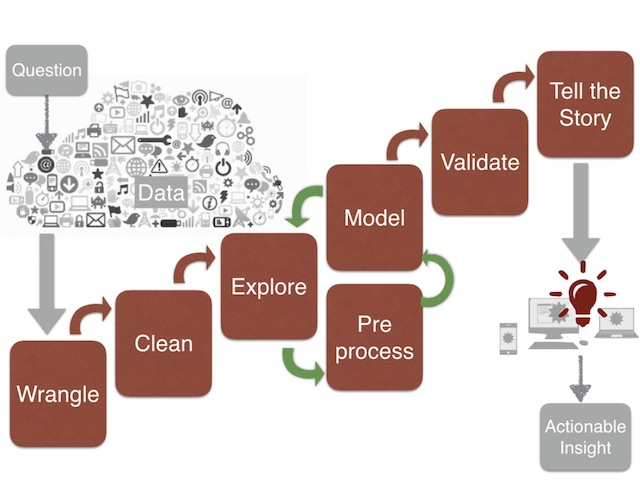

<div class="alert alert-block alert-info"><b></b></div>

## Imports
***

In [21]:
#from string import digits
import acquire
import prepare
#import requests
#from requests import get
#from bs4 import BeautifulSoup
#import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


import itertools
import re
import unicodedata
import nltk

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


#from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.corpus import stopwords
from wordcloud import WordCloud

from matplotlib.pyplot import figure

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



<div class="alert alert-block alert-info"><b></b></div>

## Data Acqusition

<div class="alert alert-block alert-info"><b></b></div>

### Web-Scraping GitHub with BeautifulSoup
***

#### 1. Identify HTML target feature using BeautifulSoup

   `Repo README.md text` - soup.select('article', class_="markdown-body entry-content container-lg")[0].text

   `Repo primary language` - soup.select('li.d-inline:nth-child(1) > a:nth-child(1)')[0].text

#### 2. Code extraction functions used to create corpus
      
     - def get_soup()   
       - This function takes in a url, parses the HTML and returns a BeautifulSoup object   

     - def get_readme_articles()   
       - This function takes in a list of urls and returns a JSON object

     - def get_urls()   
       - This function returns a list of urls that can be read in the get_readme_articles() function

     - def get_repos()   
       - This function scrapes and returns a list of repo urls from search results

### Explaination:

Using the python library BeautifulSoup the README.md text of 105 GitHub repositories were scraped. We decided to 
focus exclusivly on repositories where the `pirmary language was either Javascript or Python and the README.md was atleast 30 characters in length`. While a function that scrapes the GitHub reposity search page to return lists of reposity urls is in production, this project was conducted using repository url's collected manually.  This process consisted of a search of all GitHub user repos and added urls that fit search requirments untill 105 samples were collected.  Samples were stored in the get_urls() function and passed to get_readme_artciles() to create our reserch corpus.  
***

<div class="alert alert-block alert-info"><b></b></div>

## Data Preparation

<div class="alert alert-block alert-info"><b></b></div>

### Clean Data (prepare.py)

In [2]:
def clean_data(df): 
    # Formatt title, makes it easier to read
    df['title'] = df.title.apply(basic_clean)
    df['title'] = df.title.apply(tokenize)
    df['title'] = df.title.apply(lemmatize)
    # Formatts language makes it easier to read
    df['language'] = df.language.apply(basic_clean)
    df['language'] = df.language.apply(tokenize)
    df['language'] = df.language.apply(lemmatize)
    remove_digits = str.maketrans('', '', digits)
    df['language'] = df['language'].str.translate(remove_digits)
    df['language'] = df['language'].str.strip()
    # Formatts repo contents to make them easier to read
    df['text_cleaned'] = df.content.apply(basic_clean)
    df['text_tokenized'] = df.text_cleaned.apply(tokenize)
    df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
    df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
    # Add column with list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # Adds colum with lenght of word list
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    return df

### Explaination:

**clean_data():** This function takes in a df and `applies several functions to the title, language, and text colums` to prepare the data for exploration. This function also creates a new column with a list of words associated with each document and a new column with the lenght of each document.     

**basic_clean():** This function converts text in to ascii to remove special characters, then converts back in to utf-8.

**tokenize():** This function takes in a string and returns that string broken up in to a list of individual words.

**lemmatize():** This function takes in string for and returns a string with words simplifed to dictionary roots.
***

<div class="alert alert-block alert-info"><b></b></div>

## Data Exploration


**1. What are the most common words in READMEs?**    
**2. What does the distribution of IDFs look like for the most common words?**    
**3. Does the length of the README vary by programming language?**    
**4. Do different programming languages use a different number of unique words?**    


<div class="alert alert-block alert-info"><b></b></div>

#### Import split dataframes (train, validate, test)

In [3]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 4), (21, 4), (21, 4))

#### Visual Breakdown of Data

In [4]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    34
python        29
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered,words,doc_length
52,python,introduction reposado set tool written python ...,"[introduction, reposado, set, tool, written, p...",224
90,javascript,flowcoveragereport flowcoveragereport node com...,"[flowcoveragereport, flowcoveragereport, node,...",824
91,javascript,react native storybook content repo wa moved s...,"[react, native, storybook, content, repo, wa, ...",32
11,python,sqlalchemy python sql toolkit object relationa...,"[sqlalchemy, python, sql, toolkit, object, rel...",431
70,python,visual studio documentation welcome repo conta...,"[visual, studio, documentation, welcome, repo,...",94


<div class="alert alert-block alert-info"><b></b></div>

### Question #1. What are the most common words in READMEs?
***

In [5]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
new,162,113,49
command,161,78,83
see,159,106,53
name,156,110,46
option,148,109,39
label,148,136,12
node,140,135,5
code,139,62,77
container,136,136,0


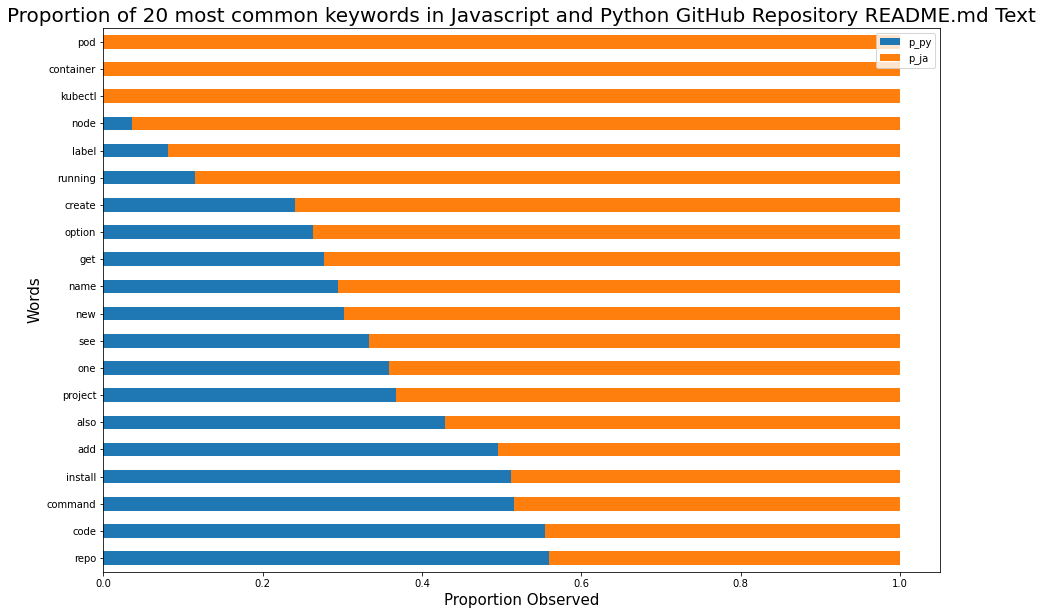

In [6]:
# visualize the percentage of the term in javascript vs. python
(word_counts.assign(p_py = word_counts.python/word_counts['all'], 
                   p_ja = word_counts.javascript/word_counts['all'])
 .sort_values(by='all')[['p_py', 'p_ja']]
 .tail(20)
 .sort_values('p_ja')
 .plot.barh(stacked=True, figsize=(15, 10))
)
plt.xlabel('Proportion Observed', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.title("Proportion of 20 most common keywords in Javascript and Python GitHub Repository README.md Text", fontsize = 20)
plt.show()

**Takeaway:**
`High proportion of most popular words are shared between repositories`
***

***Are there words that are specific only to python repositories?***

In [7]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
model,104,0,104
layer,84,0,84
ggshield,59,0,59
deeplift,52,0,52
score,49,0,49
gita,48,0,48
emotion,38,0,38
bucket,34,0,34
ipython,31,0,31
s3cmd,31,0,31


**Takeaway:**
`These words would make good features to help distinguish between repositories`
***

***Are there words that are common between repositories?***

In [8]:
#code = word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(10)

'''
This line of code provided us with a list of words that were common between repositores.  
These words were added to our prepare function and removed from our corpus.  The list of 
common removed words is as follows:
'''

# ['dictionary', 'machine', 'allow', 'directory','file','use','run','using','example',
#  'state','via','generate','right','call','end','given','filename','generated','within',
#  'however','several','info','dev','necessary','linux','together','bar']

'\nThis line of code provided us with a list of words that were common between repositores.  \nThese words were added to our prepare function and removed from our corpus.  The list of \ncommon removed words is as follows:\n'

****
#### Question #1 Takeaway:

1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)      
2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)    
`lots of overlap between lists`   
3. Common words, bad for modeling and removed      
('dictionary','machine','allow','directory','file','use','run','using',   
'example','state','via','generate','right','call','end','given','filename',    
'generated','within','however','several','info','dev','necessary','linux','together','bar')    

  

****

<div class="alert alert-block alert-info"><b></b></div>

### Question #2. What does the distribution of IDFs look like for the most common words?

In [9]:
# create tifidf object
tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)
tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)
# review common words
tfidf.vocabulary_

{'set': 37,
 'python': 33,
 'update': 42,
 'license': 20,
 'new': 26,
 'user': 44,
 'feature': 12,
 'create': 8,
 'number': 29,
 'available': 1,
 'test': 40,
 'version': 45,
 'information': 17,
 'command': 6,
 'help': 16,
 'project': 32,
 'code': 5,
 'check': 4,
 'install': 18,
 'npm': 28,
 'build': 2,
 'default': 10,
 'path': 31,
 'following': 13,
 'used': 43,
 'source': 38,
 'issue': 19,
 'ha': 15,
 'change': 3,
 'support': 39,
 'github': 14,
 'data': 9,
 'repo': 34,
 'content': 7,
 'work': 47,
 'time': 41,
 'like': 21,
 'need': 25,
 'make': 24,
 'development': 11,
 'repository': 35,
 'open': 30,
 'request': 36,
 'add': 0,
 'list': 22,
 'want': 46,
 'look': 23,
 'note': 27}

****
#### Question #2 Takeaway:

1. 1. Many of the words are overlap are found in many documents, further evidence that it may be difficult to construct a model that accuratly preicts python repositories.  
****

<div class="alert alert-block alert-info"><b></b></div>

### Question #3. Does the length of the README vary by programming language?

In [10]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]
python_train.shape, javascript_train.shape

((29, 4), (34, 4))

***
### Hypothesis Test (2 Sample T-Test)
- T-tests assumes that the continous variables are normally distributed with equivilent variance
- We need to do a quick check

In [11]:
python_train.describe()

,doc_length
count,29.000000
mean,527.482759
std,555.051196
min,5.000000
25%,123.000000
50%,261.000000
75%,712.000000
max,2109.000000


***
`Mean != Meadian: Python document length is` **NOT** `evenly distributed`
***

In [12]:
javascript_train.describe()

,doc_length
count,34.000000
mean,568.588235
std,1347.332631
min,5.000000
25%,109.250000
50%,203.500000
75%,543.250000
max,7865.000000


***
`Mean != Meadian: Javascript document length is` **NOT** `evenly distributed`
***

#### Visualized Distributions

In [ ]:
#Prepare data for visualization

# Create a corpus of all puythontext
all_words = ' '.join(python_df.text_filtered)
all_words = re.sub(r'\s.\s', '', all_words)
# Expplore corpus
all_freq = pd.Series(all_words.split()).value_counts()

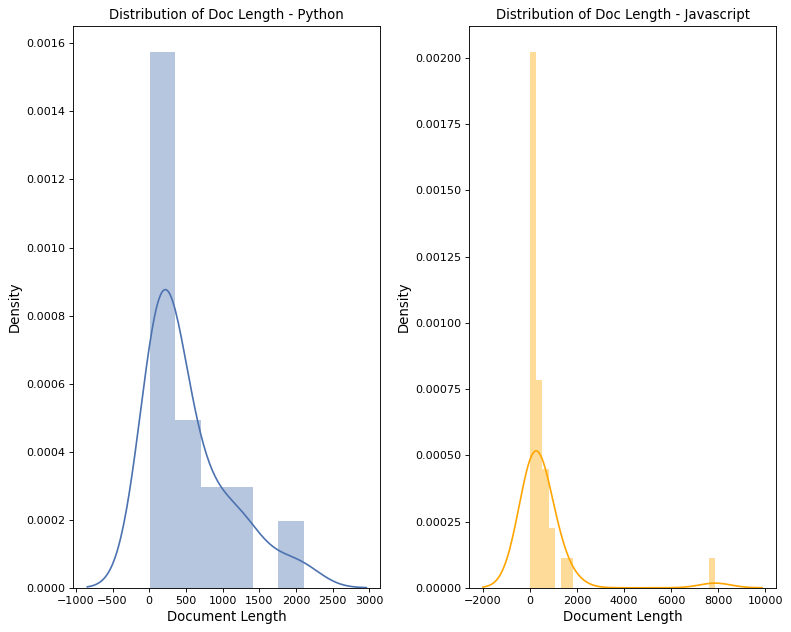

In [30]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.set_color_codes()
sns.distplot(python_train.doc_length, color ='b')
plt.title('Distribution of Doc Length - Python')
plt.xlabel('Document Length', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.subplot(122)
sns.set_color_codes()
sns.distplot(javascript_train.doc_length, color = 'orange')
plt.title('Distribution of Doc Length - Javascript')
plt.xlabel('Document Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()


#### Check the Variance

In [32]:
# Variance (2 Sample T-Test)
pvar = round(python_train.doc_length.var(),2)
jvar = round(javascript_train.doc_length.var(),2)
print(f'The variance observed in the text length of Python Repositories = {pvar}')
print(f'The variance observed in the text length of Javascript Repositories = {jvar}')

The variance observed in the text length of Python Repositories = 308081.83
The variance observed in the text length of Javascript Repositories = 1815305.22


***
**Python Variance != Javascript Variance:** 
- `equil_var = False` *needs to be added to function call*
***

#### Hypothesis Test

*Null:* There is no difference in text length between Python and Javascript README.md text

*Alternate:* There is a statistically significant difference in text length between Python and Javascript README.md text

In [33]:
# 95% Confidence Interval
alpha = 0.05

In [35]:
null = 'there is no difference in text length between Python and Javascript README.md text'
t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = -0.162
p = 0.872
is p < alpha?  False
is t > 0?  False
We fail to reject that there is no difference in text length between Python and Javascript README.md text


****
#### Question #3 Takeaway:

1. While there intitially was a statistically significant difference between repository text length, this relationshp disapeared when words were removed from the corpus.

2.  There is now **NO** statistically significant difference between repository text length.

****

<div class="alert alert-block alert-info"><b></b></div>

### Question #4. Do different programming languages use a different number of unique words?

In [41]:
# Create list of word lists(python_train)
pwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in python_train.text_filtered]
# Combine those lists in to a single list
pwords = list(itertools.chain.from_iterable(pwords))

# Create list of word lists(javascript_train)
jwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in javascript_train.text_filtered]

# Combine those lists in to a single list
jwords = list(itertools.chain.from_iterable(jwords))

# Returns words unique to python
unique_pwords = list(set(pwords) - set(jwords))

# Returns words unique to javascript
unique_jwords = list(set(jwords) - set(pwords))

print(f'There are {len(unique_pwords)} words unique to Python GitHub README.md texts.')
print(f'There are {len(unique_jwords)} words unique to Javascript GitHub README.md texts.')

There are 3140 words unique to Python GitHub README.md texts.
There are 2862 words unique to Javascript GitHub README.md texts.


****
#### Question #4 Takeaway:

1. There appear to be 300 more words unique to python repositories.
2. This observation makes sense.  Even though there is not a statistically significant difference between the text repository texts, the python repositorys are longer on average.  


****

<div class="alert alert-block alert-info"><b></b></div>

## Modeling

<div class="alert alert-block alert-info"><b></b></div>